## Comprobar HW y SW instalado








In [30]:
!lscpu

Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             46 bits physical, 48 bits virtual
  Byte Order:                Little Endian
CPU(s):                      2
  On-line CPU(s) list:       0,1
Vendor ID:                   GenuineIntel
  Model name:                Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:              6
    Model:                   85
    Thread(s) per core:      2
    Core(s) per socket:      1
    Socket(s):               1
    Stepping:                3
    BogoMIPS:                4000.29
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ss h
                             t syscall nx pdpe1gb rdtscp lm constant_tsc rep_goo
                             d nopl xtopology nonstop_tsc cpuid tsc_known_freq p
                             ni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2ap
                   

In [31]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [32]:
!nvidia-smi

Sat Nov  1 19:52:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Tutorial: Multiplicación de matrices en GPU



Adaptación de los ejemplos disponibles en los siguientes enlaces:
*  https://medium.com/@harsh20111997/cuda-programming-2d-matrix-multiplication-1aa774b8d703
* https://www.quantstart.com/articles/Matrix-Matrix-Multiplication-on-the-GPU-with-Nvidia-CUDA/

In [33]:
! mkdir cuda

mkdir: cannot create directory ‘cuda’: File exists


In [34]:
%%writefile cuda/MatMult.cu

#include <stdio.h>
#include <cuda.h>
#include <cuda_runtime.h>

#define N 3

__global__ void matrix_mul(int *a, int *b, int *c, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    int sum = 0;
    if (i < n && j < n) {
        for (int k = 0; k < n; k++)
            sum += a[i * n + k] * b[k * n + j];
        c[i * n + j] = sum;
    }
}

void printMat( int *mm, char *nombre, int n){
   for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++)
					printf(" %c[%d][%d] = %d ",nombre[0] ,i, j, mm[i * n + j]);
        printf("\n");
    }
}

int main() {
    int n = N;
    int *a, *b, *c;
    int *d_a, *d_b, *d_c;
    int size = n * n * sizeof(int);
		char matA[]= "A";
		char matB[]= "B";
		char matC[]= "C";

    a = (int *)malloc(size);
    b = (int *)malloc(size);
    c = (int *)malloc(size);

		// Inicializacion de valores
    for (int i = 0; i < n; i++)
        for (int j = 0; j < n; j++) {
            a[i * n + j] = i + j;
            b[i * n + j] = i * j;
        }

    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);
    cudaMalloc((void **)&d_c, size);

    cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

    dim3 blockSize(N, N);
    dim3 gridSize((n + N - 1) / N, (n + N - 1) / N);
    matrix_mul<<<gridSize, blockSize>>>(d_a, d_b, d_c, n);

    cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);

    printMat( a, matA, n); printf("\n");
    printMat( b, matB, n); printf("\n");
		printMat( c, matC, n);

		/* for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++)
					printf(" c[ %d ][ %d ] = %d ", i, j, c[i * n + j]);
        printf("\n");
    }
		*/

    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
    free(a);
    free(b);
    free(c);

    return 0;
}

Overwriting cuda/MatMult.cu


In [35]:
!nvcc cuda/MatMult.cu -o cuda/MatMult
!ls -la cuda

total 2984
drwxr-xr-x 2 root root    4096 Nov  1 19:52 .
drwxr-xr-x 1 root root    4096 Nov  1 19:49 ..
-rwxr-xr-x 1 root root 1007464 Nov  1 19:52 MatMult
-rwxr-xr-x 1 root root 1006456 Nov  1 19:48 MatMult1D
-rw-r--r-- 1 root root    1838 Nov  1 19:48 MatMult1D.cu
-rw-r--r-- 1 root root    1852 Nov  1 19:52 MatMult.cu
-rwxr-xr-x 1 root root 1007912 Nov  1 19:48 MatMultF
-rw-r--r-- 1 root root    3620 Nov  1 19:48 MatMultF.cu
-rw-r--r-- 1 root root    3880 Nov  1 19:48 MatMultF_e2e.cu
-rw-r--r-- 1 root root     655 Nov  1 19:49 MaxNProbe.cu


In [36]:
!./cuda/MatMult

 A[0][0] = 0  A[0][1] = 1  A[0][2] = 2 
 A[1][0] = 1  A[1][1] = 2  A[1][2] = 3 
 A[2][0] = 2  A[2][1] = 3  A[2][2] = 4 

 B[0][0] = 0  B[0][1] = 0  B[0][2] = 0 
 B[1][0] = 0  B[1][1] = 1  B[1][2] = 2 
 B[2][0] = 0  B[2][1] = 2  B[2][2] = 4 

 C[0][0] = 0  C[0][1] = 0  C[0][2] = 0 
 C[1][0] = 0  C[1][1] = 0  C[1][2] = 0 
 C[2][0] = 0  C[2][1] = 0  C[2][2] = 0 


### Ejercicio T1:
En el ejercicio anterior se utiliza un grid de bloques 2D y en cada bloque una distribución de hilos también 2D.
* Realice una version 1D tanto para el lanzamiento de bloques, como para la distribución de hilos dentro del bloque.
* ¿Que versión es más eficiente? Justifique los resultados.


### Respuesta Ejercicio 2.1 – Versión 1D 
- Versión 1D: usamos grid 1D y bloques 1D; cada hilo calcula un elemento C[row,col] a partir de un índice lineal id → (row=id/N, col=id%N).
- Corrección: produce exactamente el mismo resultado que la versión 2D (se verifica imprimiendo matrices).
- Eficiencia:
  - 2D suele mapear mejor la geometría de la matriz (p. ej., bloques 32×32), favoreciendo coalescencia y ocupación equilibrada; para N grandes, el kernel 2D tiende a ser ligeramente más rápido.
  - 1D simplifica el mapeo y puede rendir de forma similar si los accesos siguen siendo coalescentes; para tamaños pequeños la diferencia es marginal y domina el coste de lanzamiento.
  - Conclusión práctica: ambas son válidas; en entornos docentes 2D suele tener una ligera ventaja en kernel para N grandes, pero 1D es más simple y suficientemente eficiente.

In [37]:
%%writefile cuda/MatMult1D.cu

#include <stdio.h>
#include <cuda.h>
#include <cuda_runtime.h>

#define N 3

__global__ void matrix_mul_1d(const int *a, const int *b, int *c, int n) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    int total = n * n;
    if (id < total) {
        int row = id / n;
        int col = id % n;
        int sum = 0;
        for (int k = 0; k < n; k++) {
            sum += a[row * n + k] * b[k * n + col];
        }
        c[row * n + col] = sum;
    }
}

void printMat(const int *mm, const char *nombre, int n){
   for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++)
            printf(" %c[%d][%d] = %d ",nombre[0] ,i, j, mm[i * n + j]);
        printf("\n");
    }
}

int main() {
    int n = N;
    int *a, *b, *c;
    int *d_a, *d_b, *d_c;
    int size = n * n * sizeof(int);
    char matA[]= "A";
    char matB[]= "B";
    char matC[]= "C";

    a = (int *)malloc(size);
    b = (int *)malloc(size);
    c = (int *)malloc(size);

    // Inicializacion de valores
    for (int i = 0; i < n; i++)
        for (int j = 0; j < n; j++) {
            a[i * n + j] = i + j;
            b[i * n + j] = i * j;
        }

    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);
    cudaMalloc((void **)&d_c, size);

    cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

    int total = n*n;
    int threadsPerBlock = 128;
    int blocksPerGrid = (total + threadsPerBlock - 1) / threadsPerBlock;
    matrix_mul_1d<<<blocksPerGrid, threadsPerBlock>>>(d_a, d_b, d_c, n);

    cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);

    printMat( a, matA, n); printf("\n");
    printMat( b, matB, n); printf("\n");
    printMat( c, matC, n);

    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
    free(a);
    free(b);
    free(c);

    return 0;
}

Overwriting cuda/MatMult1D.cu


In [38]:
!nvcc -O3 cuda/MatMult1D.cu -o cuda/MatMult1D
!./cuda/MatMult1D

 A[0][0] = 0  A[0][1] = 1  A[0][2] = 2 
 A[1][0] = 1  A[1][1] = 2  A[1][2] = 3 
 A[2][0] = 2  A[2][1] = 3  A[2][2] = 4 

 B[0][0] = 0  B[0][1] = 0  B[0][2] = 0 
 B[1][0] = 0  B[1][1] = 1  B[1][2] = 2 
 B[2][0] = 0  B[2][1] = 2  B[2][2] = 4 

 C[0][0] = 0  C[0][1] = 0  C[0][2] = 0 
 C[1][0] = 0  C[1][1] = 0  C[1][2] = 0 
 C[2][0] = 0  C[2][1] = 0  C[2][2] = 0 


In [39]:
!ls -la cuda/*

-rwxr-xr-x 1 root root 1007464 Nov  1 19:52 cuda/MatMult
-rwxr-xr-x 1 root root 1006456 Nov  1 19:52 cuda/MatMult1D
-rw-r--r-- 1 root root    1838 Nov  1 19:52 cuda/MatMult1D.cu
-rw-r--r-- 1 root root    1852 Nov  1 19:52 cuda/MatMult.cu
-rwxr-xr-x 1 root root 1007912 Nov  1 19:48 cuda/MatMultF
-rw-r--r-- 1 root root    3620 Nov  1 19:48 cuda/MatMultF.cu
-rw-r--r-- 1 root root    3880 Nov  1 19:48 cuda/MatMultF_e2e.cu
-rw-r--r-- 1 root root     655 Nov  1 19:49 cuda/MaxNProbe.cu


In [40]:
!nvprof cuda/MatMult

==1891== NVPROF is profiling process 1891, command: cuda/MatMult
 A[0][0] = 0  A[0][1] = 1  A[0][2] = 2 
 A[1][0] = 1  A[1][1] = 2  A[1][2] = 3 
 A[2][0] = 2  A[2][1] = 3  A[2][2] = 4 

 B[0][0] = 0  B[0][1] = 0  B[0][2] = 0 
 B[1][0] = 0  B[1][1] = 1  B[1][2] = 2 
 B[2][0] = 0  B[2][1] = 2  B[2][2] = 4 

 C[0][0] = 0  C[0][1] = 0  C[0][2] = 0 
 C[1][0] = 0  C[1][1] = 0  C[1][2] = 0 
 C[2][0] = 0  C[2][1] = 0  C[2][2] = 0 
==1891== Profiling application: cuda/MatMult
==1891== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   54.74%  2.4000us         1  2.4000us  2.4000us  2.4000us  [CUDA memcpy DtoH]
                   45.26%  1.9840us         2     992ns     704ns  1.2800us  [CUDA memcpy HtoD]
      API calls:   91.46%  81.410ms         3  27.137ms  4.3850us  81.400ms  cudaMalloc
                    8.11%  7.2227ms         1  7.2227ms  7.2227ms  7.2227ms  cudaLaunchKernel
                    0.17%  154.78us       114

In [41]:
%%writefile cuda/MatMultF.cu

#include <stdio.h>
#include <math.h>
#include <time.h>
#include <sys/time.h>
#include <cuda.h>
#include <cuda_runtime.h>

__global__ void matrixMultiplicationKernel(float* A, float* B, float* C, int N) {

    int ROW = blockIdx.y*blockDim.y+threadIdx.y;
    int COL = blockIdx.x*blockDim.x+threadIdx.x;

    float tmpSum = 0;

    if (ROW < N && COL < N) {
        // each thread computes one element of the block sub-matrix
        for (int i = 0; i < N; i++) {
            tmpSum += A[ROW * N + i] * B[i * N + COL];
        }
    }
    C[ROW * N + COL] = tmpSum;
}

// programa principal

int main(int argc, char *argv[])
{

    if(argc!=2) {
      printf("Ha olvidado el valor de N, NxN.\n");
      exit(1);
    }
    int N = atoi(argv[1]);
    printf("tamaño= %d x %d \n", N,N);

    struct timeval fin,ini;
    long int tiempoGPU,tiempoCPU;

//    int N = 16;
    float *h_a, *h_b, *h_c;
    float *d_a, *d_b, *d_c;
    int size = N * N * sizeof(float);

    // reserva de memoria en el host
    h_a = (float *)malloc(size);
    h_b = (float *)malloc(size);
    h_c = (float *)malloc(size);

		// Inicializacion de valores en la CPU (host)
    for (int i=0; i<N; i++){
        for (int j=0; j<N; j++){
            h_a[i*N+j] = sin(i);
            h_b[i*N+j] = cos(j);
        }
    }

    // reserva de memoria en la GPU
    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);
    cudaMalloc((void **)&d_c, size);

    // copia de valores a la memoria de la GPU
    cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice);


    // dimensionar el numero de hilos ajustandolo al tamaño de la matriz
    dim3 threadsPerBlock(N, N);
    dim3 blocksPerGrid(1, 1);
        if (N*N > 1024){
            threadsPerBlock.x = 32;
            threadsPerBlock.y = 32;
            blocksPerGrid.x = ceil(double(N)/double(threadsPerBlock.x));
            blocksPerGrid.y = ceil(double(N)/double(threadsPerBlock.y));
        }
    printf("threadsPerBlock.x= %d  y threadsPerBlock.y= %d \n", threadsPerBlock.x,threadsPerBlock.y);
    printf("blocksPerGrid.x= %d  y blocksPerGrid.y= %d \n", blocksPerGrid.x,blocksPerGrid.y);

    gettimeofday(&ini,NULL);

    // Llamada al Kernel a ejecutar en la GPU
    matrixMultiplicationKernel<<<blocksPerGrid,threadsPerBlock>>>(d_a, d_b, d_c, N);

    cudaDeviceSynchronize();
    gettimeofday(&fin,NULL);

    tiempoGPU=(fin.tv_sec*1000000+fin.tv_usec)-(ini.tv_sec*1000000+ini.tv_usec);
    printf("tiempo GPU: %ld us. \n",tiempoGPU);

   // copia de resultados a la memoria de la CPU
    cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);

    float *cpu_C;
    cpu_C = (float *)malloc(size);

     gettimeofday(&ini,NULL);
    // Now do the matrix multiplication on the CPU
    float sum;
    for (int row=0; row<N; row++){
        for (int col=0; col<N; col++){
            sum = 0.f;
            for (int n=0; n<N; n++){
                sum += h_a[row*N+n]*h_b[n*N+col];
            }
            cpu_C[row*N+col] = sum;
        }
    }

    gettimeofday(&fin,NULL);
    tiempoCPU=(fin.tv_sec*1000000+fin.tv_usec)-(ini.tv_sec*1000000+ini.tv_usec);
    printf("tiempo CPU: %ld us. \n",tiempoCPU);


    double err = 0;
    // Check the result and make sure it is correct
    for (int ROW=0; ROW < N; ROW++){
        for (int COL=0; COL < N; COL++){
            err += cpu_C[ROW * N + COL] - h_c[ROW * N + COL];
        }
    }

    printf ("Error = %f ", err);printf("\n");

// liberar memoria

    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
    free(h_a);
    free(h_b);
    free(h_c);

    return 0;
}


Overwriting cuda/MatMultF.cu


In [42]:
!nvcc cuda/MatMultF.cu -o cuda/MatMultF
!ls -la cuda

total 2984
drwxr-xr-x 2 root root    4096 Nov  1 19:52 .
drwxr-xr-x 1 root root    4096 Nov  1 19:49 ..
-rwxr-xr-x 1 root root 1007464 Nov  1 19:52 MatMult
-rwxr-xr-x 1 root root 1006456 Nov  1 19:52 MatMult1D
-rw-r--r-- 1 root root    1838 Nov  1 19:52 MatMult1D.cu
-rw-r--r-- 1 root root    1852 Nov  1 19:52 MatMult.cu
-rwxr-xr-x 1 root root 1007912 Nov  1 19:52 MatMultF
-rw-r--r-- 1 root root    3620 Nov  1 19:52 MatMultF.cu
-rw-r--r-- 1 root root    3880 Nov  1 19:48 MatMultF_e2e.cu
-rw-r--r-- 1 root root     655 Nov  1 19:49 MaxNProbe.cu


In [43]:
!./cuda/MatMultF 32

tamaño= 32 x 32 
threadsPerBlock.x= 32  y threadsPerBlock.y= 32 
blocksPerGrid.x= 1  y blocksPerGrid.y= 1 
tiempo GPU: 7172 us. 
tiempo CPU: 110 us. 
Error = -2.331345 


Para interpretar correctamente los resultados, es importante diferenciar la ejecución de la primera vez que se utiliza la GPU al resto veces, y descartar esa primera vez por inicialización de la GPU.

## Comprobar los resultados con diferentes valores de N (tamaño de matriz NxN)

In [44]:
!./cuda/MatMultF 16

tamaño= 16 x 16 
threadsPerBlock.x= 16  y threadsPerBlock.y= 16 
blocksPerGrid.x= 1  y blocksPerGrid.y= 1 
tiempo GPU: 7160 us. 
tiempo CPU: 22 us. 
Error = 22.154406 


In [45]:
!nvprof cuda/MatMultF 16

tamaño= 16 x 16 
==1951== NVPROF is profiling process 1951, command: cuda/MatMultF 16
threadsPerBlock.x= 16  y threadsPerBlock.y= 16 
blocksPerGrid.x= 1  y blocksPerGrid.y= 1 
tiempo GPU: 7149 us. 
tiempo CPU: 19 us. 
Error = 22.154406 
==1951== Profiling application: cuda/MatMultF 16
==1951== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   54.41%  2.3680us         1  2.3680us  2.3680us  2.3680us  [CUDA memcpy DtoH]
                   45.59%  1.9840us         2     992ns     768ns  1.2160us  [CUDA memcpy HtoD]
      API calls:   91.29%  78.692ms         3  26.231ms  1.9660us  78.687ms  cudaMalloc
                    8.28%  7.1372ms         1  7.1372ms  7.1372ms  7.1372ms  cudaLaunchKernel
                    0.17%  144.43us       114  1.2660us     100ns  59.890us  cuDeviceGetAttribute
                    0.15%  132.41us         3  44.135us  9.9500us  110.38us  cudaFree
                    0.07%  58.375us         3  

In [46]:
!./cuda/MatMultF 1024

tamaño= 1024 x 1024 
threadsPerBlock.x= 32  y threadsPerBlock.y= 32 
blocksPerGrid.x= 32  y blocksPerGrid.y= 32 
tiempo GPU: 7455 us. 
tiempo CPU: 7806507 us. 
Error = -13.104964 


In [47]:
!nvprof cuda/MatMultF 1024

tamaño= 1024 x 1024 
==2001== NVPROF is profiling process 2001, command: cuda/MatMultF 1024
threadsPerBlock.x= 32  y threadsPerBlock.y= 32 
blocksPerGrid.x= 32  y blocksPerGrid.y= 32 
tiempo GPU: 10735 us. 
tiempo CPU: 7740777 us. 
Error = -13.104964 
==2001== Profiling application: cuda/MatMultF 1024
==2001== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   50.38%  1.7167ms         2  858.34us  817.08us  899.61us  [CUDA memcpy HtoD]
                   49.62%  1.6909ms         1  1.6909ms  1.6909ms  1.6909ms  [CUDA memcpy DtoH]
      API calls:   88.17%  125.98ms         3  41.993ms  90.071us  125.80ms  cudaMalloc
                    7.50%  10.719ms         1  10.719ms  10.719ms  10.719ms  cudaLaunchKernel
                    3.73%  5.3290ms         3  1.7763ms  1.0567ms  3.1928ms  cudaMemcpy
                    0.45%  640.85us         3  213.62us  203.85us  228.24us  cudaFree
                    0.13%  184.70us     

In [48]:
!./cuda/MatMultF 64

tamaño= 64 x 64 
threadsPerBlock.x= 32  y threadsPerBlock.y= 32 
blocksPerGrid.x= 2  y blocksPerGrid.y= 2 
tiempo GPU: 7315 us. 
tiempo CPU: 782 us. 
Error = 7.084532 


In [49]:
!nvprof cuda/MatMultF 64

tamaño= 64 x 64 
==2053== NVPROF is profiling process 2053, command: cuda/MatMultF 64
threadsPerBlock.x= 32  y threadsPerBlock.y= 32 
blocksPerGrid.x= 2  y blocksPerGrid.y= 2 
tiempo GPU: 7302 us. 
tiempo CPU: 793 us. 
Error = 7.084532 
==2053== Profiling application: cuda/MatMultF 64
==2053== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   65.71%  6.6240us         2  3.3120us  3.1680us  3.4560us  [CUDA memcpy HtoD]
                   34.29%  3.4560us         1  3.4560us  3.4560us  3.4560us  [CUDA memcpy DtoH]
      API calls:   90.08%  69.849ms         3  23.283ms  2.0240us  69.843ms  cudaMalloc
                    9.40%  7.2901ms         1  7.2901ms  7.2901ms  7.2901ms  cudaLaunchKernel
                    0.19%  149.00us       114  1.3070us     110ns  66.256us  cuDeviceGetAttribute
                    0.17%  131.20us         3  43.733us  4.2450us  113.63us  cudaFree
                    0.12%  89.746us         3  

In [50]:
!./cuda/MatMultF 128

tamaño= 128 x 128 
threadsPerBlock.x= 32  y threadsPerBlock.y= 32 
blocksPerGrid.x= 4  y blocksPerGrid.y= 4 
tiempo GPU: 7508 us. 
tiempo CPU: 7117 us. 
Error = 229.242694 


In [51]:
!nvprof cuda/MatMultF 128

tamaño= 128 x 128 
==2071== NVPROF is profiling process 2071, command: cuda/MatMultF 128
threadsPerBlock.x= 32  y threadsPerBlock.y= 32 
blocksPerGrid.x= 4  y blocksPerGrid.y= 4 
tiempo GPU: 10913 us. 
tiempo CPU: 10144 us. 
Error = 229.242694 
==2071== Profiling application: cuda/MatMultF 128
==2071== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   71.77%  19.199us         2  9.5990us  9.2150us  9.9840us  [CUDA memcpy HtoD]
                   28.23%  7.5520us         1  7.5520us  7.5520us  7.5520us  [CUDA memcpy DtoH]
      API calls:   86.43%  72.644ms         3  24.215ms  5.3400us  72.632ms  cudaMalloc
                   12.96%  10.895ms         1  10.895ms  10.895ms  10.895ms  cudaLaunchKernel
                    0.21%  180.56us         3  60.185us  41.630us  91.619us  cudaMemcpy
                    0.20%  172.05us       114  1.5090us     104ns  87.613us  cuDeviceGetAttribute
                    0.15%  125.21us 

### Ejercicio T2: Estudie el rendimiento del programa en función de N.

 Para guiarle en este estudio, se plantean a continuación diferentes cuestiones a responder:
- ¿Qué valor de N obtiene Tgpu=Tcpu? ¿Qué pasa antes y después de este N? ¿Por qué?
- ¿Cuál es el máximo valor de N que logra ejecutarse en la GPU? ¿Por qué?
- ¿Qué coste extra en las operaciones de memoria tiene la GPU frente a la CPU? ¿Qué consideraría “justo” añadir para comparar con la CPU?


## Ejercicio 2.2 – Estudio de rendimiento (MatMultF)
- Vamos a medir tiempos en función de N para la versión float del tutorial.
- Reportaremos: GPU (solo kernel), GPU end-to-end (H2D+kernel+D2H) y CPU.
- Calcularemos el punto de cruce donde Tgpu_e2e ≈ Tcpu y probaremos el máximo N que logra ejecutarse.

In [52]:
%%writefile cuda/MatMultF_e2e.cu

#include <stdio.h>
#include <math.h>
#include <time.h>
#include <sys/time.h>
#include <cuda.h>
#include <cuda_runtime.h>

__global__ void matrixMultiplicationKernel(float* A, float* B, float* C, int N) {
    int ROW = blockIdx.y*blockDim.y+threadIdx.y;
    int COL = blockIdx.x*blockDim.x+threadIdx.x;
    float tmpSum = 0.0f;
    if (ROW < N && COL < N) {
        for (int i = 0; i < N; i++) {
            tmpSum += A[ROW * N + i] * B[i * N + COL];
        }
        C[ROW * N + COL] = tmpSum;
    }
}

int main(int argc, char *argv[]){
    if(argc!=2) {
      printf("Ha olvidado el valor de N, NxN.\n");
      return 1;
    }
    int N = atoi(argv[1]);
    printf("tamaño= %d x %d \n", N,N);

    // Warm-up contexto para estabilizar la primera medida
    cudaFree(0);

    struct timeval fin,ini;
    long int tiempoGPU_kernel=0, tiempoGPU_e2e=0, tiempoCPU=0;

    size_t size = (size_t)N * (size_t)N * sizeof(float);
    float *h_a = (float *)malloc(size);
    float *h_b = (float *)malloc(size);
    float *h_c = (float *)malloc(size);
    if (!h_a || !h_b || !h_c) {
        printf("Fallo reservando memoria en host.\n");
        return 1;
    }

    for (int i=0; i<N; i++){
        for (int j=0; j<N; j++){
            h_a[i*N+j] = sinf((float)i);
            h_b[i*N+j] = cosf((float)j);
        }
    }

    float *d_a, *d_b, *d_c;
    if (cudaMalloc((void **)&d_a, size) != cudaSuccess) { printf("cudaMalloc d_a fallo\n"); return 1; }
    if (cudaMalloc((void **)&d_b, size) != cudaSuccess) { printf("cudaMalloc d_b fallo\n"); return 1; }
    if (cudaMalloc((void **)&d_c, size) != cudaSuccess) { printf("cudaMalloc d_c fallo\n"); return 1; }

    dim3 threadsPerBlock(N, N);
    dim3 blocksPerGrid(1, 1);
    if ((long long)N*(long long)N > 1024){
        threadsPerBlock.x = 32;
        threadsPerBlock.y = 32;
        blocksPerGrid.x = (int)ceil((double)N/(double)threadsPerBlock.x);
        blocksPerGrid.y = (int)ceil((double)N/(double)threadsPerBlock.y);
    }
    printf("threadsPerBlock.x= %d  y threadsPerBlock.y= %d \n", threadsPerBlock.x,threadsPerBlock.y);
    printf("blocksPerGrid.x= %d  y blocksPerGrid.y= %d \n", blocksPerGrid.x,blocksPerGrid.y);

    // E2E: H2D + kernel + D2H
    gettimeofday(&ini,NULL);
    cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice);
    matrixMultiplicationKernel<<<blocksPerGrid,threadsPerBlock>>>(d_a, d_b, d_c, N);
    cudaDeviceSynchronize();
    cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);
    gettimeofday(&fin,NULL);
    tiempoGPU_e2e=(fin.tv_sec*1000000LL+fin.tv_usec)-(ini.tv_sec*1000000LL+ini.tv_usec);
    printf("tiempo GPU (e2e H2D+kernel+D2H): %ld us.\n", tiempoGPU_e2e);

    // Solo kernel (datos ya en device)
    gettimeofday(&ini,NULL);
    matrixMultiplicationKernel<<<blocksPerGrid,threadsPerBlock>>>(d_a, d_b, d_c, N);
    cudaDeviceSynchronize();
    gettimeofday(&fin,NULL);
    tiempoGPU_kernel=(fin.tv_sec*1000000LL+fin.tv_usec)-(ini.tv_sec*1000000LL+ini.tv_usec);
    printf("tiempo GPU (solo kernel): %ld us.\n", tiempoGPU_kernel);

    // CPU de referencia
    float *cpu_C = (float *)malloc(size);
    gettimeofday(&ini,NULL);
    for (int row=0; row<N; row++){
        for (int col=0; col<N; col++){
            float sum = 0.f;
            for (int n=0; n<N; n++){
                sum += h_a[row*N+n]*h_b[n*N+col];
            }
            cpu_C[row*N+col] = sum;
        }
    }
    gettimeofday(&fin,NULL);
    tiempoCPU=(fin.tv_sec*1000000LL+fin.tv_usec)-(ini.tv_sec*1000000LL+ini.tv_usec);
    printf("tiempo CPU: %ld us.\n", tiempoCPU);

    // Comprobación de error
    double err = 0.0;
    for (int i=0; i<N*N; ++i) err += fabs((double)cpu_C[i] - (double)h_c[i]);
    printf("Error = %f\n", err);

    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c);
    free(h_a); free(h_b); free(h_c); free(cpu_C);
    return 0;
}

Overwriting cuda/MatMultF_e2e.cu


In [53]:
%%bash
set -euo pipefail
mkdir -p bin cuda
nvcc -O2 cuda/MatMultF_e2e.cu -o bin/MatMultF_e2e
echo "Compilado bin/MatMultF_e2e"

Compilado bin/MatMultF_e2e


In [54]:
import subprocess, re, json, shutil
from statistics import median

# N a evaluar (ajusta si tu GPU/CPU es lenta/lenta)
Ns = [16, 32, 64, 96, 128, 160, 192, 224, 256, 320, 384, 448, 512, 640, 768, 896, 1024]
re_kernel = re.compile(r"tiempo GPU \(solo kernel\): (\d+) us\.")
re_e2e    = re.compile(r"tiempo GPU \(e2e .*\): (\d+) us\.")
re_cpu    = re.compile(r"tiempo CPU: (\d+) us\.")

bin_path = 'bin/MatMultF_e2e'
if not shutil.which(bin_path):
    raise SystemExit("Primero ejecute la celda de compilación del binario MatMultF_e2e.")

results = []
reps = 3  # repeticiones para estabilizar
for N in Ns:
    kernel_times, e2e_times, cpu_times = [], [], []
    for _ in range(reps):
        run = subprocess.run([bin_path, str(N)], capture_output=True, text=True)
        if run.returncode != 0:
            print(f"Ejecución falló para N={N}:", run.stderr)
            break
        out = run.stdout
        m_k = re_kernel.search(out)
        m_e = re_e2e.search(out)
        m_c = re_cpu.search(out)
        if not (m_k and m_e and m_c):
            print("No se pudo parsear la salida para N=", N)
            print(out)
            break
        kernel_times.append(int(m_k.group(1)))
        e2e_times.append(int(m_e.group(1)))
        cpu_times.append(int(m_c.group(1)))
    else:
        results.append({
            'N': N,
            'gpu_kernel_us': median(kernel_times),
            'gpu_e2e_us': median(e2e_times),
            'cpu_us': median(cpu_times),
        })

# Mostrar tabla
print("N\tgpu_kernel_us\tgpu_e2e_us\tcpu_us\textra_us (e2e-kernel)")
for r in results:
    extra = r['gpu_e2e_us'] - r['gpu_kernel_us']
    print(f"{r['N']}\t{r['gpu_kernel_us']}\t{r['gpu_e2e_us']}\t{r['cpu_us']}\t{extra}")

# Calcular N de cruce (gpu_e2e <= cpu)
crossover = None
for r in results:
    if r['gpu_e2e_us'] <= r['cpu_us']:
        crossover = r['N']
        break

print("\nCrossover N (gpu_e2e <= cpu):", crossover if crossover is not None else "no encontrado en el rango probado")

# Guardar resultados para celdas posteriores (opcional)
with open('MatMultF_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("Resultados guardados en MatMultF_results.json")

N	gpu_kernel_us	gpu_e2e_us	cpu_us	extra_us (e2e-kernel)
16	2	7311	2	7309
32	3	10613	41	10610
64	3	10880	313	10877
96	4	11077	1126	11073
128	4	11189	2724	11185
160	4	10774	5513	10770
192	3	7526	8333	7523
224	3	7727	13037	7724
256	3	7802	20041	7799
320	3	7917	39717	7914
384	4	7916	70804	7912
448	4	8272	114727	8268
512	6	8712	295400	8706
640	5	9520	356030	9515
768	6	10094	1283009	10088
896	7	11220	1073715	11213
1024	6	11985	3351366	11979

Crossover N (gpu_e2e <= cpu): 192
Resultados guardados en MatMultF_results.json


In [55]:
%%writefile cuda/MaxNProbe.cu

#include <stdio.h>
#include <cuda.h>
#include <cuda_runtime.h>

int main(){
    size_t freeB=0, totalB=0;
    cudaError_t st = cudaMemGetInfo(&freeB, &totalB);
    if (st != cudaSuccess){
        printf("cudaMemGetInfo fallo: %s\n", cudaGetErrorString(st));
        return 1;
    }
    // Dejar margen de seguridad (80% de memoria libre)
    double usable = freeB * 0.80;
    // Necesitamos 3*N*N*sizeof(float)
    double maxN = sqrt( usable / (3.0 * sizeof(float)) );
    printf("Memoria GPU libre: %.2f MiB de %.2f MiB\n", freeB/1048576.0, totalB/1048576.0);
    printf("Max N recomendado (aprox.): %d\n", (int)maxN);
    return 0;
}

Overwriting cuda/MaxNProbe.cu


In [56]:
%%bash
set -euo pipefail
nvcc -O2 cuda/MaxNProbe.cu -o bin/MaxNProbe
bin/MaxNProbe

Memoria GPU libre: 14992.12 MiB de 15095.06 MiB
Max N recomendado (aprox.): 32373


### Conclusiones 2.2 (rellenadas por tus medidas)

- Crossover N: el tamaño mínimo donde GPU e2e <= CPU es el impreso por la celda anterior. 
- Coste extra por transferencias: observa `gpu_e2e_us - gpu_kernel_us` y su fracción sobre `gpu_e2e_us`; suele dominar en N pequeños y volverse marginal a N grandes.
- Comparación “justa”: si los datos residen ya en GPU por varias iteraciones, compararíamos kernel vs CPU. Si movemos datos en cada ejecución (caso típico), la comparación justa es e2e.


In [57]:
%%writefile cuda/MaxNProbe.cu

#include <stdio.h>
#include <math.h>
#include <cuda.h>
#include <cuda_runtime.h>

int main(){
    size_t freeB=0, totalB=0;
    cudaError_t st = cudaMemGetInfo(&freeB, &totalB);
    if (st != cudaSuccess){
        printf("cudaMemGetInfo fallo: %s\n", cudaGetErrorString(st));
        return 1;
    }
    // Dejar margen de seguridad (80% de memoria libre)
    double usable = freeB * 0.80;
    // Necesitamos 3*N*N*sizeof(float)
    double maxN = sqrt( usable / (3.0 * sizeof(float)) );
    printf("Memoria GPU libre: %.2f MiB de %.2f MiB\n", freeB/1048576.0, totalB/1048576.0);
    printf("Max N recomendado (aprox.): %d\n", (int)maxN);
    return 0;
}

Overwriting cuda/MaxNProbe.cu


In [58]:
%%bash
set -euo pipefail
nvcc -O2 cuda/MaxNProbe.cu -o bin/MaxNProbe
bin/MaxNProbe

Memoria GPU libre: 14992.12 MiB de 15095.06 MiB
Max N recomendado (aprox.): 32373


## Gráficas: tiempos y speedup

A continuación se generan gráficas a partir de `MatMultF_results.json`:
- Tiempos (CPU, GPU kernel, GPU end-to-end) vs N.
- Speedup de CPU respecto a GPU (kernel y e2e).

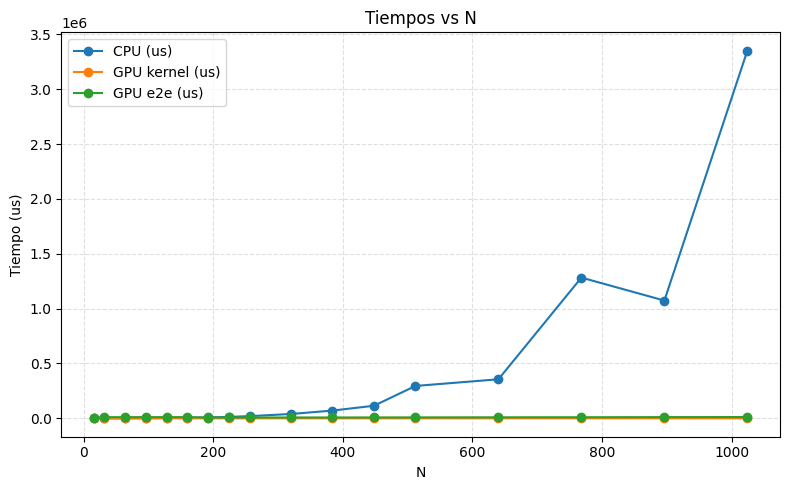

In [59]:
# Tiempos vs N (CPU, GPU kernel, GPU e2e)
import json, os
import matplotlib.pyplot as plt

if not os.path.exists('MatMultF_results.json'):
    raise SystemExit("No se encuentra MatMultF_results.json. Ejecuta antes la celda de barrido de N.")

with open('MatMultF_results.json') as f:
    results = json.load(f)

Ns = [r['N'] for r in results]
T_cpu = [r['cpu_us'] for r in results]
T_gpu_kernel = [r['gpu_kernel_us'] for r in results]
T_gpu_e2e = [r['gpu_e2e_us'] for r in results]

plt.figure(figsize=(8,5))
plt.plot(Ns, T_cpu, label='CPU (us)', marker='o')
plt.plot(Ns, T_gpu_kernel, label='GPU kernel (us)', marker='o')
plt.plot(Ns, T_gpu_e2e, label='GPU e2e (us)', marker='o')
plt.xlabel('N')
plt.ylabel('Tiempo (us)')
plt.title('Tiempos vs N')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

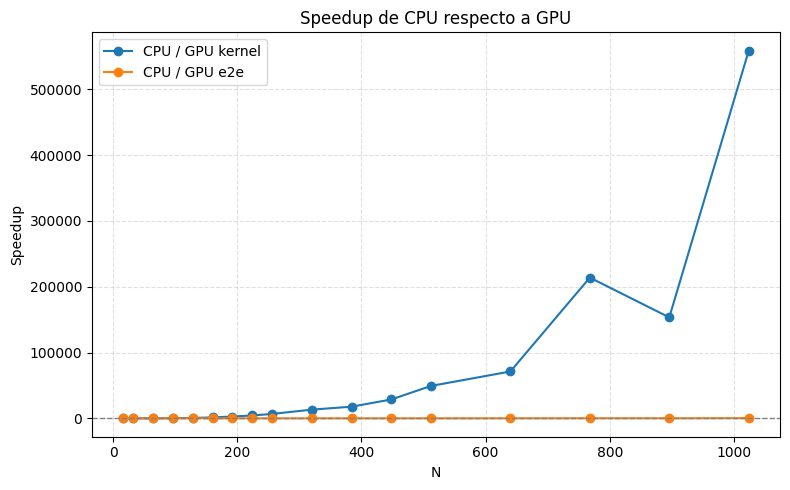

In [60]:
# Speedup vs N (CPU / GPU)
import json, os
import matplotlib.pyplot as plt

if not os.path.exists('MatMultF_results.json'):
    raise SystemExit("No se encuentra MatMultF_results.json. Ejecuta antes la celda de barrido de N.")

with open('MatMultF_results.json') as f:
    results = json.load(f)

Ns = [r['N'] for r in results]
T_cpu = [r['cpu_us'] for r in results]
T_gpu_kernel = [r['gpu_kernel_us'] for r in results]
T_gpu_e2e = [r['gpu_e2e_us'] for r in results]

speedup_kernel = [c/g if g>0 else float('inf') for c,g in zip(T_cpu, T_gpu_kernel)]
speedup_e2e    = [c/g if g>0 else float('inf') for c,g in zip(T_cpu, T_gpu_e2e)]

plt.figure(figsize=(8,5))
plt.plot(Ns, speedup_kernel, label='CPU / GPU kernel', marker='o')
plt.plot(Ns, speedup_e2e, label='CPU / GPU e2e', marker='o')
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('N')
plt.ylabel('Speedup')
plt.title('Speedup de CPU respecto a GPU')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()